In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# standardize random numbers for reproducibility
torch.manual_seed(0)


In [ ]:
# input layer, a single hidden layer, and an output layer
# Define hyperparameters
input_size = 784  # 28x28 pixels
hidden_size = 128
num_classes = 10



batch_size = 100

In [ ]:
img = torchvision.datasets.MNIST(root='../data', train=True, download=True)[0]

100%|██████████| 9912422/9912422 [00:00<00:00, 77836730.53it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 96522465.20it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21432329.97it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 970529.77it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
# Load MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),   # convert to pytorch tensor
     transforms.Normalize((0.1307,), (0.3081,))  # standardize the values with mean + std
    ]
)


train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


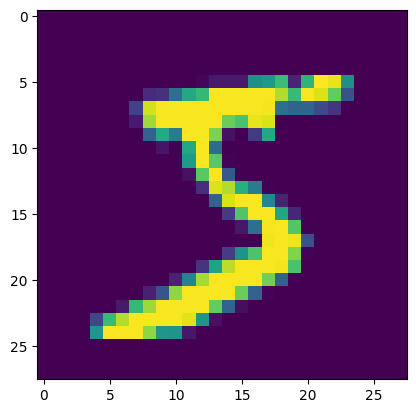

In [ ]:
# transpose the array to (28, 28) format expected by Matplotlib
array = np.squeeze(np.transpose(train_dataset[0][0], (1, 2, 0)))

# plot the image using Matplotlib
plt.imshow(array)
plt.show()



In [ ]:
next(iter(test_loader))[0].shape

torch.Size([100, 1, 28, 28])

In [ ]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Create the model
model = NeuralNet(input_size, hidden_size, num_classes)

In [ ]:
list(model.parameters())

In [ ]:
# Loss function options
cross_entropy_loss = nn.CrossEntropyLoss()
nll_loss = nn.NLLLoss()
mse_loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
input_size

784

In [ ]:
# Function to train the model
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()

    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0

        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):

            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()

            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        # Compute the average loss over all batches for this epoch and print it
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [ ]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    # Put the model in evaluation mode
    model.eval()

    # Initialize empty lists to store true and predicted labels
    y_true, y_pred = [], []

    # Disable gradient computation since we're only evaluating the model
    with torch.no_grad():
        # Iterate over each batch in the test loader
        for images, labels in test_loader:
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)

            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)

            # Find the predicted class for each image in the batch
            _, predicted = torch.max(outputs.data, 1)

            # Append the true and predicted labels for this batch to the lists
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    # Calculate evaluation metrics using the true and predicted labels
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    # Compute the accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Define a dictionary of loss functions
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),  # requires logsoftmax output (according to docs, so loss will be wrong without it!)
    'MultiMarginLoss': nn.MultiMarginLoss()
}

In [ ]:
# Train and evaluate the model using different loss functions
for loss_name, loss_function in loss_functions.items():
    print(f'Training with {loss_name}:')

    # Initialize a new model and optimizer for each loss function
    model = NeuralNet(input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, loss_function, train_loader, optimizer, num_epochs=5)

    # Evaluate the model
    accuracy, f1, precision, recall = evaluate_model(model, test_loader)
    print(f'Performance metrics for {loss_name}:')
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Training with CrossEntropyLoss:
Epoch [1/5], Loss: 0.2867
Epoch [2/5], Loss: 0.1258
Epoch [3/5], Loss: 0.0861
Epoch [4/5], Loss: 0.0670
Epoch [5/5], Loss: 0.0527
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9759, F1-score: 0.9758, Precision: 0.9760, Recall: 0.9757

Training with NLLLoss:
Epoch [1/5], Loss: -11629.0163
Epoch [2/5], Loss: -84473.9955
Epoch [3/5], Loss: -222202.7951
Epoch [4/5], Loss: -413130.6928
Epoch [5/5], Loss: -650429.2433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance metrics for NLLLoss:
Accuracy: 0.1135, F1-score: 0.0204, Precision: 0.0114, Recall: 0.1000

Training with MultiMarginLoss:
Epoch [1/5], Loss: 0.0418
Epoch [2/5], Loss: 0.0151
Epoch [3/5], Loss: 0.0100
Epoch [4/5], Loss: 0.0076
Epoch [5/5], Loss: 0.0060
Performance metrics for MultiMarginLoss:
Accuracy: 0.9728, F1-score: 0.9728, Precision: 0.9734, Recall: 0.9725



In [ ]:
n = 1

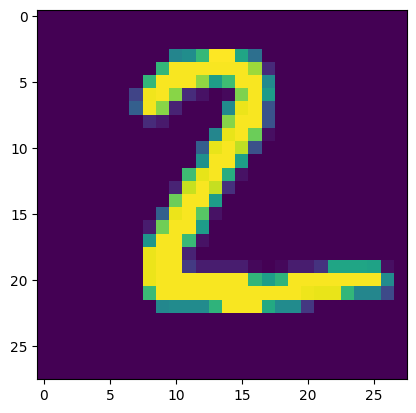

2

In [ ]:
# transpose the array to (28, 28) format expected by Matplotlib
array = np.squeeze(np.transpose(test_dataset[n][0], (1, 2, 0)))

# plot the image using Matplotlib
plt.imshow(array)
plt.show()

test_dataset[n][1]

In [ ]:
test = test_dataset[n][0]
test = test.reshape(-1, input_size)

res = model(test)
res = res - res.min()
res = res / res.sum()

list(enumerate(res[0].tolist()))

[(0, 0.07732362300157547),
 (1, 0.16925065219402313),
 (2, 0.23232944309711456),
 (3, 0.15754617750644684),
 (4, 0.0),
 (5, 0.12553849816322327),
 (6, 0.08706894516944885),
 (7, 0.01678610034286976),
 (8, 0.12242855131626129),
 (9, 0.011727998964488506)]

In [ ]:
_, ans = torch.max(res, 1)
ans.item()

2